# Multiclass Classification (OVR, OVO, Output)

## Импорт библиотек

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import timeit
from sklearn.metrics import roc_auc_score, accuracy_score

## Загрузка данных и краткое знакомство с ними

Данные можно получить по следующей ссылке: [датасет о пингвинах](https://www.kaggle.com/datasets/julianmazoarroyave/pinguinos?resource=download).

**Описание данных:**
1. species - вид пингвина (Adelie, Chinstrap, Gentoo);
2. island - остров, на котором проживает вид (Torgersen, Biscoe, Dream);
3. bill_length_mm - длина клюва пингвина в миллиметрах;
4. bill_depth_mm - высота клюва пингвина в миллиметрах;
5. flipper_length_mm - длина плавника пингвина в миллиметрах;
6. body_mass_g - вес пингвина в граммах;
7. sex - пол пингвина.

В рамках данного датасета нужно решить задачу предсказания вида пингвина - многоклассовая классификация.

In [227]:
data = pd.read_csv('penguins.csv')

In [228]:
data.sample(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
284,Gentoo,Biscoe,45.8,14.2,219.0,4700.0,FEMALE
249,Gentoo,Biscoe,50.0,15.3,220.0,5550.0,MALE
102,Adelie,Biscoe,37.7,16.0,183.0,3075.0,FEMALE


In [229]:
data.shape

(344, 7)

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [231]:
data.isna().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11


Качество данных достаточно не плохое, есть немного пропусков, с которыми позже нужно будет разобраться.

В завершении данного блока посмотрим ещё на распределение классов.

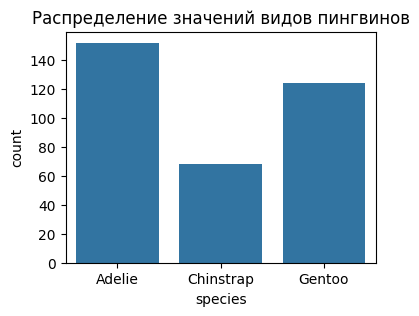

In [232]:
plt.figure(figsize=(4, 3))
sns.countplot(data=data, x='species')
plt.title('Распределение значений видов пингвинов')
plt.show()

Некоторый дисбаланс есть, можно будет поиграться с методами балансировки.

## Работа с пропусками и значениями

Так как данных не много, то можно напрямую посмотреть на строки с пропусками.

In [233]:
data[data.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


У нас есть две строки, в которых количество пропусков не позволит восстановить значения, их удалим. Для отсальных строк будем вставлять значения при помощи KNNImputer.

Но вставку будем делать не сразу, а сначала проведём EDA. Поступим так как для KNN очень важен одинаковый масштаб признаков, а сейчас он далеко не одинаковый.

In [234]:
data = data[data.isna().sum(axis=1) <= 1]

## EDA

In [235]:
cat_cols = ['island', 'sex']
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Посмотрим на корреляцию признаков с целевой переменной (species).

/tmp/ipython-input-3348115860.py:10: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


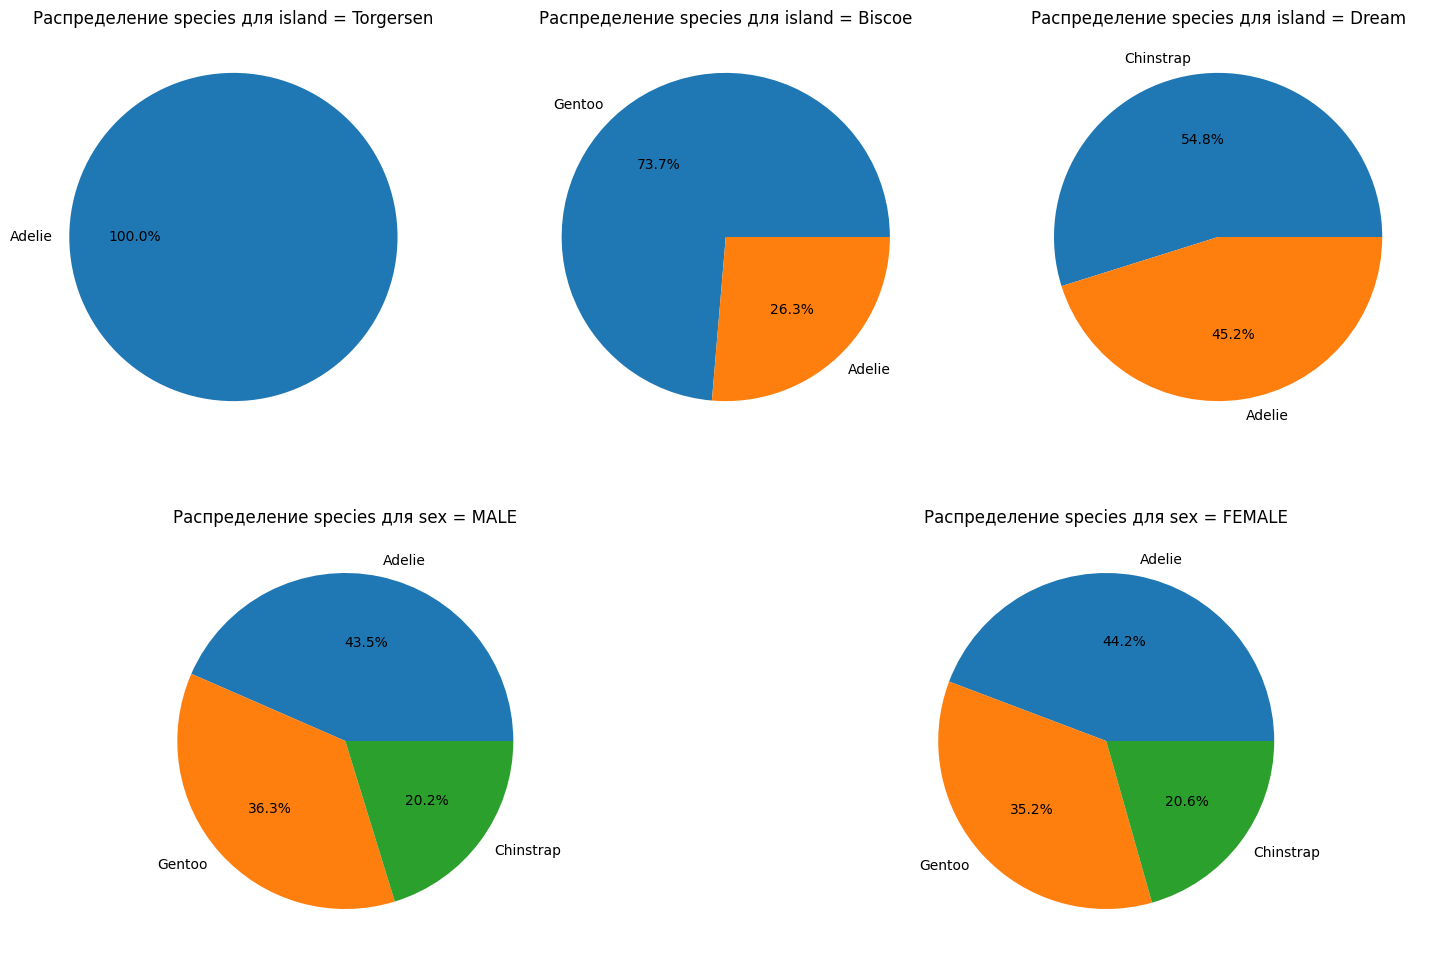

In [236]:
plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols):
    for j, val in enumerate(data[col].dropna().unique()):
        plt.subplot(2, data[col].nunique(), (i * data[col].nunique()) + j + 1)
        temp = data.loc[data[col] == val, 'species'].value_counts().reset_index()
        plt.pie(x=temp['count'], labels=temp['species'], autopct='%1.1f%%')
        plt.title(f'Распределение species для {col} = {val}')

plt.tight_layout()
plt.show()

Видно, что с оствровом у вида очень большая корреляция, а вот пол напрямую почти никак не коррелирует с видом пингвина.

Теперь посмотрим на корреляцию целевой переменной с числовыми признаками.

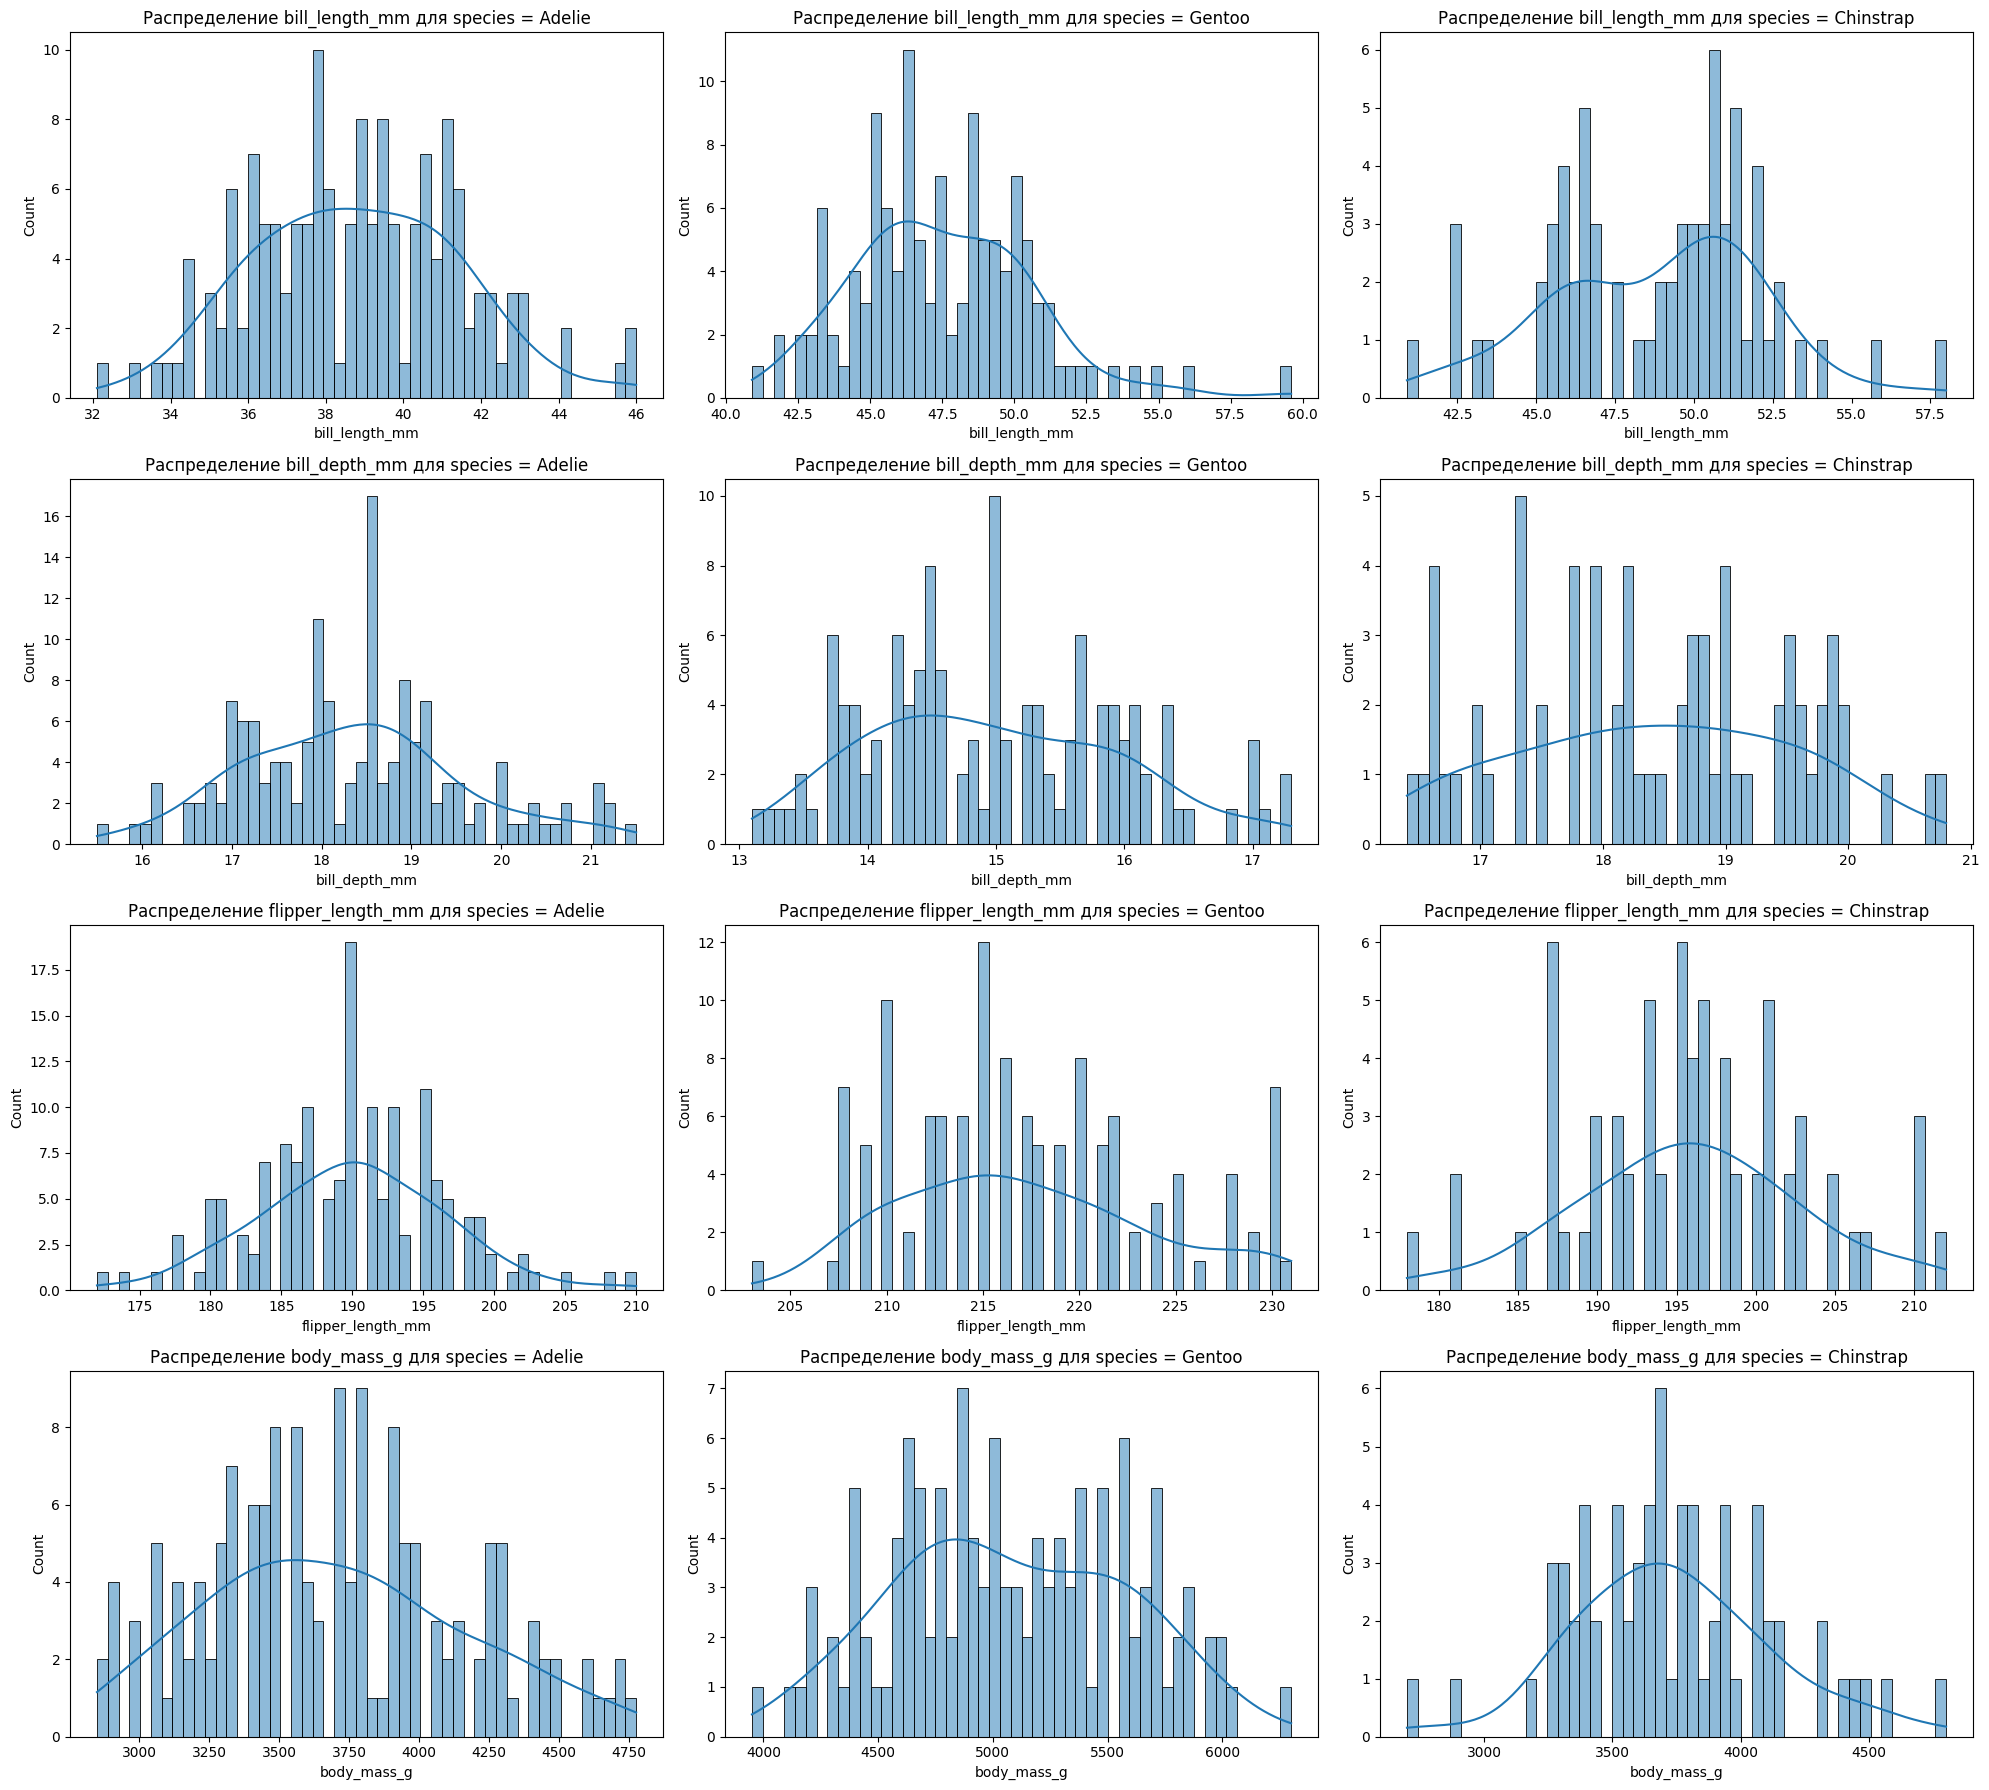

In [237]:
plt.figure(figsize=(20, 18))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 3, i * 3 + 1)
    sns.histplot(data=data.query("species == 'Adelie'"), x=col, bins=50, kde=True)
    plt.title(f'Распределение {col} для species = Adelie')

    plt.subplot(len(num_cols), 3, i * 3 + 2)
    sns.histplot(data=data.query("species == 'Gentoo'"), x=col, bins=50, kde=True)
    plt.title(f'Распределение {col} для species = Gentoo')

    plt.subplot(len(num_cols), 3, i * 3 + 3)
    sns.histplot(data=data.query("species == 'Chinstrap'"), x=col, bins=50, kde=True)
    plt.title(f'Распределение {col} для species = Chinstrap')

plt.tight_layout()
plt.show()

По этим графикам можно сделать вывод, что признаки значимые + можно дать следующую характеристику по видам:
- Gentoo - пингвины с длинными низкими клювами, большими плавниками и массой. Другими словами крупные пингвины.

- Adelie - пингвины с короткими низкими клювами, невысокой длиной плавников и невысокой массой. Можно сказать, что это не крупные пингвины, среди которых, тем неменее попадаются и некоторые крупные (дотягиваются до Gentoo).

- Chinstar - пингвины с длиными низкими клювами, короткими плавниками и невыской массой. Можно сказать, что это небольшие пингвины с длинными клювами.

Таким образом, пожалуй, все признаки важны кроме пола, с ним прямой корреляции нет (но сразу удалять данный столбец не будем).

## Подготовка данных

In [238]:
# данные для multioutput regression
ml_outpt_data = data

**Кодирование категориальных признаков.**

In [239]:
island_features = pd.get_dummies(data['island'], prefix='island', drop_first=True)
data = pd.concat([data, island_features], axis=1)
data.drop(columns='island', inplace=True)

In [240]:
data['sex'] = data['sex'].apply(lambda x: 0 if pd.notna(x) and x == 'FEMALE' else x if pd.isna(x) else 1)

In [241]:
lb_enc = LabelEncoder()

data['species'] = lb_enc.fit_transform(data['species'])

**Перевод грамм в килограммы для массы пингвина.**

In [242]:
data['body_mass_g'] = data['body_mass_g'].apply(lambda x: x / 1000)

**Перевод миллиметров в дециметры для плавников пингвина**

In [243]:
data['flipper_length_mm'] = data['flipper_length_mm'].apply(lambda x: x / 100)

 **Перевод миллиметров в сантиметры для длины и высоты клюва пингвина.**

In [244]:
data['bill_length_mm'] = data['bill_length_mm'].apply(lambda x: x / 10)
data['bill_depth_mm'] = data['bill_depth_mm'].apply(lambda x: x / 10)

**Масштабирование данных**

In [245]:
rb_scaler = RobustScaler()

data[num_cols] = rb_scaler.fit_transform(data[num_cols])

**Заполнение пропусков в признаке sex.**

In [246]:
imputer = KNNImputer(n_neighbors=3, weights='distance')

imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

data['sex'] = imputed['sex']

**Разделение данных.**

In [247]:
X = data.drop(columns='species')
y = data['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Обучение моделей

### Функции предсказаний для OVO и OutputCode

Так как для `ROC-AUC` нужны вероятности, то нужен не просто `predict`, а `predict_proba`. Однако у OVO и OutputCode нет `predict_proba` или его аналогов, поэтому нужно реализовать специальные функции для получения вероятностей.

Функция OutputCode.

In [ ]:
def out_predict(model, X_test):
    model = model.best_estimator_

    code_book = model.code_book_
    n_classes = code_book.shape[0]

    binary_predictions = np.array([clf.predict(X_test) for clf in model.estimators_]).T

    distances = np.zeros((len(X_test), n_classes))
    for i in range(n_classes):
        hamming_dist = np.sum(binary_predictions != code_book[i], axis=1)
        distances[:, i] = hamming_dist

    scores = -distances
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)

    return proba

Функция для OVO.

In [ ]:
def ovo_predict(model, X_test):
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    return softmax(model.decision_function(X_test))

### Обучение моделей

**Логистическая регрессия.**

In [ ]:
ovr_logreg = OneVsRestClassifier(LogisticRegression())
ovo_logreg = OneVsOneClassifier(LogisticRegression())
out_logreg = OutputCodeClassifier(LogisticRegression())

logreg_param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.arange(0.001, 1.0, 0.01),
    'estimator__max_iter': [50, 100, 200, 300, 400],
    'estimator__solver': ['liblinear']
}

ovr_logreg = GridSearchCV(
    estimator=ovr_logreg,
    param_grid=logreg_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

ovo_logreg = GridSearchCV(
    estimator=ovo_logreg,
    param_grid=logreg_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

logreg_param_grid_out = {
    'code_size': [0.8, 1.0, 1.4, 2],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.arange(0.001, 1.0, 0.01),
    'estimator__max_iter': [50, 100, 200, 300, 400],
    'estimator__solver': ['liblinear']
}
out_logreg = GridSearchCV(
    estimator=out_logreg,
    param_grid=logreg_param_grid_out,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

In [ ]:
ovr_logreg_taken = timeit.timeit(
    lambda: ovr_logreg.fit(X_train, y_train),
    number=1
)
print(ovr_logreg_taken)

29.34885510600003


In [ ]:
ovo_logreg_taken = timeit.timeit(
    lambda: ovo_logreg.fit(X_train, y_train),
    number=1
)
print(ovo_logreg_taken)

17.22263510500005


In [ ]:
out_logreg_taken = timeit.timeit(
    lambda: out_logreg.fit(X_train, y_train),
    number=1
)
print(out_logreg_taken)

108.73573327399998


**Метод ближайших соседей.**

In [ ]:
ovr_knn = OneVsRestClassifier(KNeighborsClassifier())
ovo_knn = OneVsOneClassifier(KNeighborsClassifier())
out_knn = OutputCodeClassifier(KNeighborsClassifier())

knn_param_grid = {
    'estimator__n_neighbors': [4, 6, 10],
    'estimator__metric': ['manhattan', 'euclidean']
}

ovr_knn = GridSearchCV(
    estimator=ovr_knn,
    param_grid=knn_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

ovo_knn = GridSearchCV(
    estimator=ovo_knn,
    param_grid=knn_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

knn_param_grid_out = {
    'code_size': [0.8, 1.0, 1.4, 2],
    'estimator__n_neighbors': [4, 6, 10],
    'estimator__metric': ['manhattan', 'euclidean']
}
out_knn = GridSearchCV(
    estimator=out_knn,
    param_grid=knn_param_grid_out,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

In [ ]:
ovr_knn_taken = timeit.timeit(
    lambda: ovr_knn.fit(X_train, y_train),
    number=1
)
print(ovr_knn_taken)

0.29752951499995106


In [ ]:
ovo_knn_taken = timeit.timeit(
    lambda: ovo_knn.fit(X_train, y_train),
    number=1
)
print(ovo_knn_taken)

0.3070531950000941


In [ ]:
out_knn_taken = timeit.timeit(
    lambda: out_knn.fit(X_train, y_train),
    number=1
)
print(out_knn_taken)

1.5156126770000355


**Метод опорных векторов.**

In [ ]:
ovr_svm = OneVsRestClassifier(SVC())
ovo_svm = OneVsOneClassifier(SVC())
out_svm = OutputCodeClassifier(SVC())

svm_param_grid = {
    'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'estimator__C': [0.001, 0.01, 0.1],
    'estimator__gamma': [0.001, 0.01, 0.1]
}

ovr_svm = GridSearchCV(
    estimator=ovr_svm,
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

ovo_svm = GridSearchCV(
    estimator=ovo_svm,
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

svm_param_grid_out = {
    'code_size': [0.8, 1.0, 1.4, 2],
    'estimator__C': [0.001, 0.01, 0.1],
    'estimator__gamma': [0.001, 0.01, 0.1]
}
out_svm = GridSearchCV(
    estimator=out_svm,
    param_grid=svm_param_grid_out,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

In [ ]:
ovr_svm_taken = timeit.timeit(
    lambda: ovr_svm.fit(X_train, y_train),
    number=1
)
print(ovr_svm_taken)

1.1634898180000164


In [ ]:
ovo_svm_taken = timeit.timeit(
    lambda: ovo_svm.fit(X_train, y_train),
    number=1
)
print(ovo_svm_taken)

0.9914468819999911


In [ ]:
out_svm_taken = timeit.timeit(
    lambda: out_svm.fit(X_train, y_train),
    number=1
)
print(out_svm_taken)

2.001640091000013


**Наивный байесовский классификатор.**

In [ ]:
ovr_gnb = OneVsRestClassifier(GaussianNB())
ovo_gnb = OneVsOneClassifier(GaussianNB())
out_gnb = OutputCodeClassifier(GaussianNB())

gbn_param_grid = {
    'estimator__var_smoothing': [0.5, 1.0, 1.5]
}

ovr_gnb = GridSearchCV(
    estimator=ovr_gnb,
    param_grid=gbn_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

ovo_gnb = GridSearchCV(
    estimator=ovo_gnb,
    param_grid=gbn_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

gbn_param_grid_out = {
    'code_size': [0.8, 1.0, 1.4, 2],
    'estimator__var_smoothing': [0.5, 1.0, 1.5]
}
out_gnb = GridSearchCV(
    estimator=out_gnb,
    param_grid=gbn_param_grid_out,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

In [ ]:
ovr_gnb_taken = timeit.timeit(
    lambda: ovr_gnb.fit(X_train, y_train),
    number=1
)
print(ovr_gnb_taken)

0.10985636899999918


In [ ]:
ovo_gnb_taken = timeit.timeit(
    lambda: ovo_gnb.fit(X_train, y_train),
    number=1
)
print(ovo_gnb_taken)

0.08846081900014724


In [ ]:
out_gnb_taken = timeit.timeit(
    lambda: out_gnb.fit(X_train, y_train),
    number=1
)
print(out_gnb_taken)

0.4251790079999864


**Дерево решений.**

In [ ]:
ovr_tree = OneVsRestClassifier(DecisionTreeClassifier())
ovo_tree = OneVsOneClassifier(DecisionTreeClassifier())
out_tree = OutputCodeClassifier(DecisionTreeClassifier())

tree_param_grid = {
    'estimator__max_depth': [1, 2, 4, 6, 8],
    'estimator__min_samples_split': [2, 4, 6, 10, 16],
    'estimator__min_samples_leaf': [2, 4, 6, 8],
    'estimator__criterion': ['gini', 'entropy']
}

ovr_tree = GridSearchCV(
    estimator=ovr_tree,
    param_grid=tree_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

ovo_tree = GridSearchCV(
    estimator=ovo_tree,
    param_grid=tree_param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

tree_param_grid_out = {
    'code_size': [0.8, 1.0, 1.4, 2],
    'estimator__max_depth': [1, 2, 4, 6, 8],
    'estimator__min_samples_split': [2, 4, 6, 10, 16],
    'estimator__min_samples_leaf': [2, 4, 6, 8],
    'estimator__criterion': ['gini', 'entropy']
}
out_tree = GridSearchCV(
    estimator=out_tree,
    param_grid=tree_param_grid_out,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)

In [ ]:
ovr_tree_taken = timeit.timeit(
    lambda: ovr_tree.fit(X_train, y_train),
    number=1
)
print(ovr_tree_taken)

5.041378271000212


In [ ]:
ovo_tree_taken = timeit.timeit(
    lambda: ovo_tree.fit(X_train, y_train),
    number=1
)
print(ovo_tree_taken)

3.838881680999748


In [ ]:
out_tree_taken = timeit.timeit(
    lambda: out_tree.fit(X_train, y_train),
    number=1
)
print(out_tree_taken)

22.46751582700017


## Сравнение моделей

Теперь сделаем сравнительную таблицу с качеством модлей и их временем обучения.

In [ ]:
times_times = (
    [ovr_logreg_taken, ovr_knn_taken, ovr_svm_taken, ovr_gnb_taken, ovr_tree_taken],
    [ovo_logreg_taken, ovo_knn_taken, ovo_svm_taken, ovo_gnb_taken, ovo_tree_taken],
    [out_logreg_taken, out_knn_taken, out_svm_taken, out_gnb_taken, out_tree_taken]
)

models_models = [
    [ovr_logreg, ovr_knn, ovr_svm, ovr_gnb, ovr_tree],
    [ovo_logreg, ovo_knn, ovo_svm, ovo_gnb, ovo_tree],
    [out_logreg, out_knn, out_svm, out_gnb, out_tree]
]

types_model = ['logreg', 'knn', 'svm', 'gnb', 'tree']
types_train = ['ovr', 'ovo', 'out']

In [ ]:
matrix = dict()

matrix['models'] = types_model
for type_train, times, models in zip(types_train, times_times, models_models):
    matrix[type_train] = []
    matrix[f'{type_train}_time'] = times

    for type_model, model in zip(types_model, models):
        predictions = None

        if type_train == 'ovr':
            if type_model == 'svm':
                predictions = ovo_predict(model, X_test)

            elif type_model == 'tree':
                predictions = model.predict_proba(X_test)
                nan_rows = np.all(np.isnan(predictions), axis=1)
                predictions[nan_rows] = 1.0 / 3.0

            else:
                predictions = model.predict_proba(X_test)

        elif type_train == 'ovo':
            predictions = ovo_predict(model, X_test)

        else:
            predictions = out_predict(model, X_test)

        matrix[type_train].append(roc_auc_score(y_test, predictions, multi_class='ovr'))

/usr/local/lib/python3.12/dist-packages/sklearn/multiclass.py:557: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


In [ ]:
pd.DataFrame(matrix)

,models,ovr,ovr_time,ovo,ovo_time,out,out_time
0,logreg,1.000000,29.348855,1.000000,17.222635,0.893119,108.735733
1,knn,1.000000,0.297530,1.000000,0.307053,0.995395,1.515613
2,svm,1.000000,1.163490,1.000000,0.991447,0.567011,2.001640
3,gnb,0.993093,0.109856,0.993715,0.088461,0.954268,0.425179
4,tree,0.992314,5.041378,0.993507,3.838882,0.838837,22.467516


По получившимся результатам я бы сказал следующее:
1. Время.

    К сожалению по времени обучения ничего сказать нельзя, так как оно по идее не соответствует свойствам типов обучения. Вероятно такая картина наблюдается из-за небольшого объёма датасета, при котором случайность вычислений (то быстрее отработал процессор - доступно больше ядер, то медленее - ядра были заняты) имела больший вес, чем размер модели и датасета.

    Но скажу следующее, мы должны были получить ovr_time $\leq$ out_time $\leq$ ovo_time, так как количество параметров в моделях как раз и должно было соответствовать данному неравенству.

2. Качество.

    При прочих равных ovo был чуть лучше, чем ovr, что и логично. Наверное, если бы данных было больше, то разница была существеннее. Что касается качества out-метода, то оно получилось плохим, вероятно это из-за нестабильного размера кодовой книги да и метода в целом (каким-то мне он показался странным и ненадёжным)

3. Модель.

    По моделям лучшими оказались KNN и наивный байесовский классификатор, что и не удивительно, всё-таки данные модели более выразительны, чем логистическая регрессия. Качество решающих деревьев и метода опорных векторов, скорее всего, отстало ввиду не самого лучше подбора гиперпараметров (если бы я выбрал более широкий их спектр, то смог бы получить качество получьше).

По итогу можно сказать, что для решения данной задачи лучше всего выбрать метод обучения OVO и выбрать в качестве модели KNN или GNB. Размер датасета легко позволит использовать OVO (он более точный по своему естеству, чем OVR) + сами данные лучше аппроксимируются нелинейными моделями, такими как KNN или GNB.

# Multilabel Classification

## Импорт библиотек

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import timeit
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

## Загрузка данных и их беглый осмотр

Данный можно найти по ссылке: [датасет](https://www.kaggle.com/datasets/arashnic/flu-data?select=H1N1_Flu_Vaccines.csv).

In [135]:
df = pd.read_csv('H1N1_Flu_Vaccines.csv')

**Описание данных:**
- Целевые переменные
    - h1n1_vaccine: Получил ли респондент вакцину против гриппа H1N1.
    - seasonal_vaccine: Получил ли респондент сезонную вакцину от гриппа.
1. age_group — возрастная группа респондента.
2. образование — самооцененный уровень образования.
3. раса — раса ответчика.
4. пол — пол респондента.
5. income_poverty - Годовой доход домохозяйства респондента по порогам бедности по переписи 2008 года.
6. marital_status - Семейное положение ответчика.
7. rent_or_own - Жилищная ситуация респондента.
8. employment_status - Трудовой статус ответчика.
9. h1n1_concern — уровень беспокойства по поводу гриппа H1N1.
0 = Совсем не обеспокоен; 1 = Не очень; 2 = Отчасти обеспокоен; 3 = Очень обеспокоен.
10. h1n1_knowledge - Уровень знаний о гриппе H1N1.
0 = Нет знаний; 1 = Немного знаний; 2 = Много знаний.
11. behavioral_wash_hands — часто мыл руки или использовал антисептик. (бинарный)
12. behavioral_large_gatherings — Сокращает время на больших собраниях. (бинарный)
13. behavioral_antiviral_meds — принимал противовирусные препараты. (бинарный)
14. behavioral_avoidance - Избегал тесного контакта с другими людьми с симптомами, похожими на грипп. (бинарный)
15. behavioral_face_mask — Купил маску для лица. (бинарный)
16. behavioral_outside_home — Имеет меньшее количество контактов с людьми вне собственного дома. (бинарный)
17. behavioral_touch_face — избегал прикосновения к глазам, носу или рту. (бинарный)
18. doctor_recc_h1n1 - Врач рекомендовал вакцину от гриппа H1N1. (бинарный)
19. doctor_recc_seasonal - Врач рекомендовал вакцину от сезонного гриппа. (бинарный)
20. chronic_med_condition — Имеет любое из следующих хронических заболеваний: астма или другое заболевание лёгких, диабет, заболевание сердца, заболевание почек, серповидноклеточная анемия или другую анемию, неврологическое или нервно-мышечное заболевание, заболевание печени или ослабленную иммунную систему, вызванную хроническим заболеванием или лекарствами, принимаемыми при хроническом заболевании. (бинарный)
21. child_under_6_months — регулярно контактирует с ребенком младше шести месяцев. (бинарный)
22. health_worker — работает медицинским работником. (бинарный)
23. health_insurance — У него есть медицинская страховка. (бинарный)
24. opinion_h1n1_vacc_effective — мнение респондента об эффективности вакцины против H1N1.
1 = Совсем не эффективно; 2 = Не очень; 3 = Не знаю; 4 = Отчасти эффективно; 5 = Очень эффективно.
25. opinion_h1n1_risk — мнение респондента о риске заболеть гриппом H1N1 без вакцинации.
1 = Очень низко; 2 = Немного низко; 3 = Не знаю; 4 = Немного высоко; 5 = Очень высоко.
26. opinion_h1n1_sick_from_vacc — Опасения респондента заболеть из-за вакцинации против H1N1.
1 = Совсем не переживаю; 2 = Не очень волнуюсь; 3 = Не знаю; 4 = Немного переживаю; 5 = Очень переживаю.
27. opinion_seas_vacc_effective — мнение респондента об эффективности сезонной вакцины против гриппа.
1 = Совсем не эффективно; 2 = Не очень; 3 = Не знаю; 4 = Отчасти эффективно; 5 = Очень эффективно.
28. opinion_seas_risk — мнение респондента о риске заболеть сезонным гриппом без вакцинации.
1 = Очень низко; 2 = Немного низко; 3 = Не знаю; 4 = Немного высоко; 5 = Очень высоко.
29. opinion_seas_sick_from_vacc — опасения респондента заболеть из-за вакцинации от сезонного гриппа.
1 = Совсем не переживаю; 2 = Не очень волнуюсь; 3 = Не знаю; 4 = Немного переживаю; 5 = Очень переживаю.
30. hhs_geo_region — Место жительства респондента по географической классификации по 10 регионам, определённой Министерством здравоохранения и социальных служб США. Значения представлены в виде коротких случайных строк символов.
31. census_msa - Место жительства респондента в столичных статистических районах (MSA), определенных переписью населения США.
32. household_adults — Количество других взрослых в домохозяйстве, верхнее кодирование до 3.
33. household_children - Количество детей в домохозяйстве, верхнее число 3.
34. employment_industry — тип отрасли, в которой работает респондент. Значения представлены в виде коротких случайных строк символов.
36. employment_occupation - Тип занятия ответчика. Значения представлены в виде коротких случайных строк символов.

**В общем будем предсказывать получил ли человек вакцину от свиного группи и сезонную вакцину от гриппа.**

Посмотрим немного на данные и их размерность.

In [136]:
df.sample(3)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
17769,17769,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Own,Employed,fpwskwrf,"MSA, Not Principle City",0.0,0.0,saaquncn,vlluhbov,1,1
21300,21300,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Own,Employed,lzgpxyit,"MSA, Not Principle City",1.0,3.0,wxleyezf,emcorrxb,0,1
19895,19895,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",2.0,3.0,fcxhlnwr,cmhcxjea,1,1


In [137]:
df.shape

(26707, 38)

Теперь посмотрим есть ли пропуски в данных.

In [138]:
missing_features = df.isna().sum().reset_index()
missing_features[missing_features[0] > 0]

,index,0
1,h1n1_concern,92
2,h1n1_knowledge,116
3,behavioral_antiviral_meds,71
4,behavioral_avoidance,208
5,behavioral_face_mask,19
6,behavioral_wash_hands,42
7,behavioral_large_gatherings,87
8,behavioral_outside_home,82
9,behavioral_touch_face,128
10,doctor_recc_h1n1,2160


Пропусков очень много, будем думать как с ними работать дальше.

В завершении посмотрим на распределения целевых переменных.

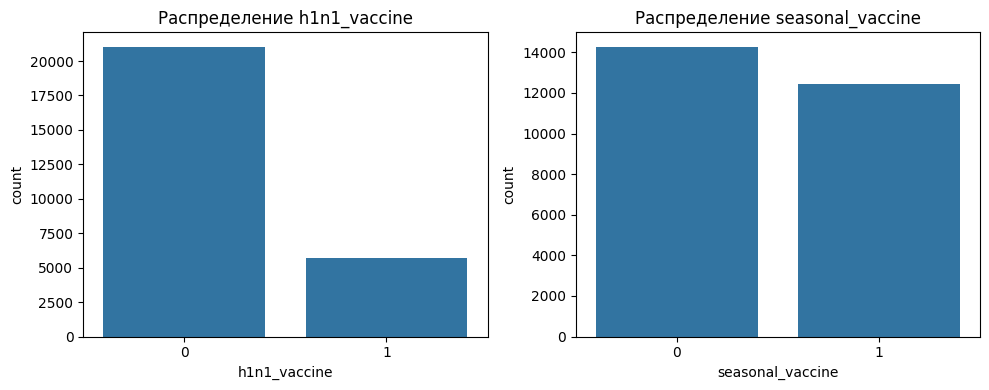

In [139]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='h1n1_vaccine')
plt.title('Распределение h1n1_vaccine')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='seasonal_vaccine')
plt.title('Распределение seasonal_vaccine')

plt.tight_layout()
plt.show()

Ну в целом можно сказать, что прям жёсткого дисбаланса нет, поэтому можно особо ничего и не делать.

## Обработка пропусков

Признаков и пропуско очень много, поэтому сильно погружаться не будем в данные (колоссальное количество времени займёт).

В начале посмотрим на смысл пропусков в каждом столбце и решим что с ними будем делать.

1. **h1n1_concern** - тут пропуски означают просто пропуски, что данных просто нет.
2. **h1n1_knowledge** - тут пропуски просто означают отсутствие данных.
3. **behavioral_antiviral_meds** - тут пропуски означают отсутствие данных.
4. **behavioral_avoidance** - тут пропуски означают отсутствие данных.
5. **behavioral_face_mask** - тут пропуски означают отсутствие данных.
6. **behavioral_wash_hands** - тут пропуски означают отсутствие данных.
7. **behavioral_large_gatherings** - тут пропуски означают отсутствие данных.
8. **behavioral_outside_home** - тут пропуски означают отсутствие данных.
9. **behavioral_touch_face** - тут пропуски означают отсутствие данных.
10. **doctor_rec_h1n1** - тут пропуски можно приравнять к тому, что пациент не был у врача (делаем для пропусков значение `not visit doctor`.
11. **doctor_recc_seasonal** - всё аналогично признаку doctor_recc_h1n1.
12. **chronic_med_condition** - тут пропуски означают отсутствие данных и ничего более.
13. **child_under_6_month** - тут пропуски означают, что данных просто нет.
14. **health_worker** - тут пропуски означают отсутствие данных.
15. **health_insurance** - тут пропуски означают отсутствие данных.
16. **option_h1n1_vacc_effective** - тут пропуски означают отсутствие данных.
17. **opinion_h1n1_risk** - тут пропуски означают отсутствие данных.

..

35. последний признак с пропусками.

Можно сказать, что во всех признаках пропуски не являются какими либо особенными или значащими. Скорее всего, такие пропуски означают просто, что респондент не заполнил соответствующее поле, поэтому для каждого признака вместо пропуска будем добавлять значение `no_data`.



Сейчас заполним пропуски и проведём кодировку категориальных данных для признаков, в которых больше 2 категорий.

In [140]:
cat_cols_with_nan_for_dummies = [
    'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
    'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
    'education', 'race', 'income_poverty',
    'employment_status', 'hhs_geo_region', 'census_msa',
    'employment_industry', 'employment_occupation']

for col in cat_cols_with_nan_for_dummies:
    col_features = pd.get_dummies(df[col], prefix=col, dummy_na=True)
    df = pd.concat([df, col_features], axis=1)
    df = df.drop(columns=col)

Теперь учтём пропуски для бинарных данных (кодировку проводить не будем).

In [141]:
cat_cols_with_nan_binary = [
    'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask',
    'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home',
    'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
    'chronic_med_condition', 'child_under_6_months', 'health_worker',
    'health_insurance', 'marital_status', 'rent_or_own'
]

for col in cat_cols_with_nan_binary:
    df[f'{col}_nan'] = df[col].apply(lambda x: 0 if pd.notna(x) else 1)

Теперь проведём кодировку для бинарных категориальных признаков.

In [142]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

df['marital_status'] = df['marital_status'].apply(lambda x: 1 if pd.notna(x) and x == 'Married' else 0)

df['rent_or_own'] = df['rent_or_own'].apply(lambda x: 1 if pd.notna(x) and x == 'Own' else 0)

df['doctor_recc_h1n1'] = df['doctor_recc_h1n1'].apply(lambda x: x if pd.notna(x) else 0)

df['health_insurance'] = df['health_insurance'].apply(lambda x: x if pd.notna(x) else 0)

Признаки `household_adults` и `household_children` заполним при помощи KNNImputer.

In [143]:
imputer = KNNImputer(n_neighbors=3, weights='distance')

imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

df['household_adults'] = imputed['household_adults']
df['household_children'] = imputed['household_children']

## Удаление ненужных столбцов

In [144]:
target_columns = ['h1n1_vaccine', 'seasonal_vaccine']

Удалис столбцы которые сильно коррелируют между собой.

In [145]:
corr_matrix = df.corr().abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_triangle.columns
            if any(upper_triangle[column] >= 0.5) and col not in target_columns]

print(f"Будет удалено {len(to_drop)} столбцов.")

df_filtered = df.drop(columns=to_drop)

Будет удалено 38 столбцов.


Сначала удалим столбцы, которые слабо коррелируют с целевыми переменными.

In [146]:
target_columns = ['h1n1_vaccine', 'seasonal_vaccine']

correlations = df_filtered.corr()[target_columns]

mask = (abs(correlations[target_columns[0]]) < 0.2) & (abs(correlations[target_columns[1]]) < 0.2)

low_corr_columns = mask[mask].index.tolist()

low_corr_columns = [col for col in low_corr_columns if col not in target_columns]

df_filtered = df_filtered.drop(columns=low_corr_columns)

print(f"Удалено столбцов: {len(low_corr_columns)}")

Удалено столбцов: 115


Отлично, осталость только разделить и отмасштабировать данные и переходить к задаче классификации.

## Разделение данных и масштабирование

In [147]:
X = df_filtered.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = df_filtered[['h1n1_vaccine', 'seasonal_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
rb_scaler = RobustScaler()

X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

Теперь можно переходить к обучению моделей.

## Обучение моделей

### ChainClassifier

**Логистическая регрессия.**

In [150]:
chain_multilabel_logreg = ClassifierChain(LogisticRegression())

logreg_param_grid = {
    'base_estimator__penalty': ['l1', 'l2'],
    'base_estimator__C': np.arange(0.001, 1.0, 0.01),
    'base_estimator__max_iter': [50, 100, 200, 300, 400],
    'base_estimator__solver': ['liblinear']
}

chain_multilabel_logreg = GridSearchCV(
    estimator=chain_multilabel_logreg,
    param_grid=logreg_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [151]:
chain_multilabel_logreg_taken = timeit.timeit(
    lambda: chain_multilabel_logreg.fit(X_train, y_train),
    number=1
)
print(chain_multilabel_logreg_taken)

84.87736962000054


**KNN.**

In [154]:
chain_multilabel_knn = ClassifierChain(KNeighborsClassifier())

knn_param_grid = {
    'base_estimator__n_neighbors': [4, 6, 10],
    'base_estimator__metric': ['manhattan', 'euclidean']
}

chain_multilabel_knn = GridSearchCV(
    estimator=chain_multilabel_knn,
    param_grid=knn_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [155]:
chain_multilabel_knn_taken = timeit.timeit(
    lambda: chain_multilabel_knn.fit(X_train, y_train),
    number=1
)
print(chain_multilabel_knn_taken)

34.02325319599913


**Метод опорных векторов.**

In [161]:
chain_multilabel_svm = ClassifierChain(SVC())

svm_param_grid = {
    'base_estimator__C': [0.01, 0.1]
}

chain_multilabel_svm = GridSearchCV(
    estimator=chain_multilabel_svm,
    param_grid=svm_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [162]:
chain_multilabel_svm_taken = timeit.timeit(
    lambda: chain_multilabel_svm.fit(X_train, y_train),
    number=1
)
print(chain_multilabel_svm_taken)

113.3236908809995


**Наивный Байесовский классификатор.**

In [165]:
chain_multilabel_gbn = ClassifierChain(GaussianNB())

gbn_param_grid = {
    'base_estimator__var_smoothing': [0.5, 1.0, 1.5]
}

chain_multilabel_gbn = GridSearchCV(
    estimator=chain_multilabel_gbn,
    param_grid=gbn_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [166]:
chain_multilabel_gbn_taken = timeit.timeit(
    lambda: chain_multilabel_gbn.fit(X_train, y_train),
    number=1
)
print(chain_multilabel_gbn_taken)

3.8065444989988464


**Решающее дерево.**

In [167]:
chain_multilabel_tree = ClassifierChain(DecisionTreeClassifier())

tree_param_grid = {
    'base_estimator__max_depth': [1, 2, 4, 6, 8],
    'base_estimator__min_samples_split': [2, 4, 6, 10, 16],
    'base_estimator__min_samples_leaf': [2, 4, 6, 8],
    'base_estimator__criterion': ['gini', 'entropy']
}

chain_multilabel_tree = GridSearchCV(
    estimator=chain_multilabel_tree,
    param_grid=tree_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [168]:
chain_multilabel_tree_taken = timeit.timeit(
    lambda: chain_multilabel_tree.fit(X_train, y_train),
    number=1
)
print(chain_multilabel_tree_taken)

10.480342368002312


#### Сравнение моделей

In [193]:
times = [
    chain_multilabel_logreg_taken,
    chain_multilabel_knn_taken,
    chain_multilabel_svm_taken,
    chain_multilabel_gbn_taken,
    chain_multilabel_tree_taken
]

models = [
    chain_multilabel_logreg,
    chain_multilabel_knn,
    chain_multilabel_svm,
    chain_multilabel_gbn,
    chain_multilabel_tree
]


matrix = dict()
matrix['models'] = ['logreg', 'knn', 'svm', 'gnb', 'tree']
matrix['avg'] = []
matrix['time'] = times

np_round = np.vectorize(lambda x: round(x, 2))

for model in models:
    avg_loss = roc_auc_score(y_test, model.predict(X_test))

    matrix['avg'].append(avg_loss)

In [194]:
chain_matrix = pd.DataFrame(matrix)

### MultioutputClassifier

**Логистическая регрессия.**

In [181]:
mloutpt_multilabel_logreg = MultiOutputClassifier(LogisticRegression())

logreg_param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': np.arange(0.001, 1.0, 0.01),
    'estimator__max_iter': [50, 100, 200, 300, 400],
    'estimator__solver': ['liblinear']
}

mloutpt_multilabel_logreg = GridSearchCV(
    estimator=mloutpt_multilabel_logreg,
    param_grid=logreg_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [182]:
mloutpt_multilabel_logreg_taken = timeit.timeit(
    lambda: mloutpt_multilabel_logreg.fit(X_train, y_train),
    number=1
)
print(mloutpt_multilabel_logreg_taken)

73.21462580400112


**KNN.**

In [183]:
mloutpt_multilabel_knn = MultiOutputClassifier(KNeighborsClassifier())

knn_param_grid = {
    'estimator__n_neighbors': [4, 6, 10],
    'estimator__metric': ['manhattan', 'euclidean']
}

mloutpt_multilabel_knn = GridSearchCV(
    estimator=mloutpt_multilabel_knn,
    param_grid=knn_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [184]:
mloutpt_multilabel_knn_taken = timeit.timeit(
    lambda: mloutpt_multilabel_knn.fit(X_train, y_train),
    number=1
)
print(mloutpt_multilabel_knn_taken)

16.03543780200198


**Метод опорных векторов.**

In [185]:
mloutpt_multilabel_svm = MultiOutputClassifier(SVC())

svm_param_grid = {
    'estimator__C': [0.01, 0.1]
}

mloutpt_multilabel_svm = GridSearchCV(
    estimator=mloutpt_multilabel_svm,
    param_grid=svm_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [186]:
mloutpt_multilabel_svm_taken = timeit.timeit(
    lambda: mloutpt_multilabel_svm.fit(X_train, y_train),
    number=1
)
print(mloutpt_multilabel_svm_taken)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


52.4732952810009


**Наивный Байесовский классификатор.**

In [187]:
mloutpt_multilabel_gbn = MultiOutputClassifier(GaussianNB())

gbn_param_grid = {
    'estimator__var_smoothing': [0.5, 1.0, 1.5]
}

mloutpt_multilabel_gbn = GridSearchCV(
    estimator=mloutpt_multilabel_gbn,
    param_grid=gbn_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [188]:
mloutpt_multilabel_gbn_taken = timeit.timeit(
    lambda: mloutpt_multilabel_gbn.fit(X_train, y_train),
    number=1
)
print(mloutpt_multilabel_gbn_taken)

0.4381826919998275


**Решающее дерево.**

In [189]:
mloutpt_multilabel_tree = MultiOutputClassifier(DecisionTreeClassifier())

tree_param_grid = {
    'estimator__max_depth': [1, 2, 4, 6, 8],
    'estimator__min_samples_split': [2, 4, 6, 10, 16],
    'estimator__min_samples_leaf': [2, 4, 6, 8],
    'estimator__criterion': ['gini', 'entropy']
}

mloutpt_multilabel_tree = GridSearchCV(
    estimator=mloutpt_multilabel_tree,
    param_grid=tree_param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

In [190]:
mloutpt_multilabel_tree_taken = timeit.timeit(
    lambda: mloutpt_multilabel_tree.fit(X_train, y_train),
    number=1
)
print(mloutpt_multilabel_tree_taken)

7.220815707998554


#### Сравнение моделей

In [195]:
times = [
    mloutpt_multilabel_logreg_taken,
    mloutpt_multilabel_knn_taken,
    mloutpt_multilabel_svm_taken,
    mloutpt_multilabel_gbn_taken,
    mloutpt_multilabel_tree_taken
]

models = [
    mloutpt_multilabel_logreg,
    mloutpt_multilabel_knn,
    mloutpt_multilabel_svm,
    mloutpt_multilabel_gbn,
    mloutpt_multilabel_tree
]


matrix = dict()
matrix['models'] = ['logreg', 'knn', 'svm', 'gnb', 'tree']
matrix['avg'] = []
matrix['time'] = times

np_round = np.vectorize(lambda x: round(x, 2))

for model in models:
    avg_loss = roc_auc_score(y_test, model.predict(X_test))

    matrix['avg'].append(avg_loss)

In [196]:
multioutpt_matrix = pd.DataFrame(matrix)

## Итог

Итог для ChainClassificator

In [197]:
chain_matrix

,models,avg,time
0,logreg,0.659789,84.877370
1,knn,0.667621,34.023253
2,svm,0.652037,113.323691
3,gnb,0.583643,3.806544
4,tree,0.667441,10.480342


Итог для MultioutputClassifier

In [198]:
multioutpt_matrix

,models,avg,time
0,logreg,0.679518,73.214626
1,knn,0.669555,16.035438
2,svm,0.672198,52.473295
3,gnb,0.614206,0.438183
4,tree,0.675925,7.220816


**Вывод:**

- Время выполнения.
    Явно время выполнения для MultioutputClassifier меньше, так как классификаторы в этом подходе независимы и обучаются не последовательно, а параллельно, что и даёт выигрыш во времени.

- Качество.
    Качество в MultioutputClassifier выше. Вероятно это связано с тем, что целевые переменные независимы (не имеют между собой корреляции) и использование целевой переменной для вычисления последующей тут не выигрышное и только мешает обучению.

По итогу для данной задачи Multioutput лучше (быстре и качество выше).

# Multioutput Regression

## Импорт библиотек

In [248]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

## Разбор данных

Будем использовать датасет про пингвинов. Мы уже знаем как их предобрабатывать, сделаем по-быстрому это ниже.

In [249]:
# кодирование категориального столбца island
island_features = pd.get_dummies(ml_outpt_data['island'], prefix='island', drop_first=True)
ml_outpt_data = pd.concat([ml_outpt_data, island_features], axis=1)
ml_outpt_data.drop(columns='island', inplace=True)

# кодирование категориального столбца sex
ml_outpt_data['sex'] = ml_outpt_data['sex'].apply(lambda x: 0 if pd.notna(x) and x == 'FEMALE' else x if pd.isna(x) else 1)

# кодирование категориального столбца species
species_features = pd.get_dummies(ml_outpt_data['species'], prefix='species', drop_first=True)
ml_outpt_data = pd.concat([ml_outpt_data, species_features], axis=1)
ml_outpt_data.drop(columns='species', inplace=True)

# перевод веса пингвина из грамм в килограммы
ml_outpt_data['body_mass_g'] = ml_outpt_data['body_mass_g'].apply(lambda x: x / 1000)

# перевод длины плавников из миллиметров в дециметры
ml_outpt_data['flipper_length_mm'] = ml_outpt_data['flipper_length_mm'].apply(lambda x: x / 100)

# перевод длины клюва из миллиметров в сантиметры
ml_outpt_data['bill_length_mm'] = ml_outpt_data['bill_length_mm'].apply(lambda x: x / 10)

# перевод высоты клюва из миллиметров в сантиметры
ml_outpt_data['bill_depth_mm'] = ml_outpt_data['bill_depth_mm'].apply(lambda x: x / 10)

# заполнение пропусков в признаке sex
imputer = KNNImputer(n_neighbors=3, weights='distance')
imputed = pd.DataFrame(imputer.fit_transform(ml_outpt_data), columns=ml_outpt_data.columns, index=ml_outpt_data.index)
ml_outpt_data['sex'] = imputed['sex']

Теперь данные готовы и можно идти дальше.

В задаче Multioutput Regression предсказываются сразу несколько целевых переменных. Чтобы это всё работало целевые переменные (как я читал в разных источниках) должны коррелировать между собой, то есть между ними должна быть взаимосвязь.

Поэтому посмотрим на матрицу корреляций данных и попытаемся понять, какие признаки можно использовать в качестве целевых переменных.

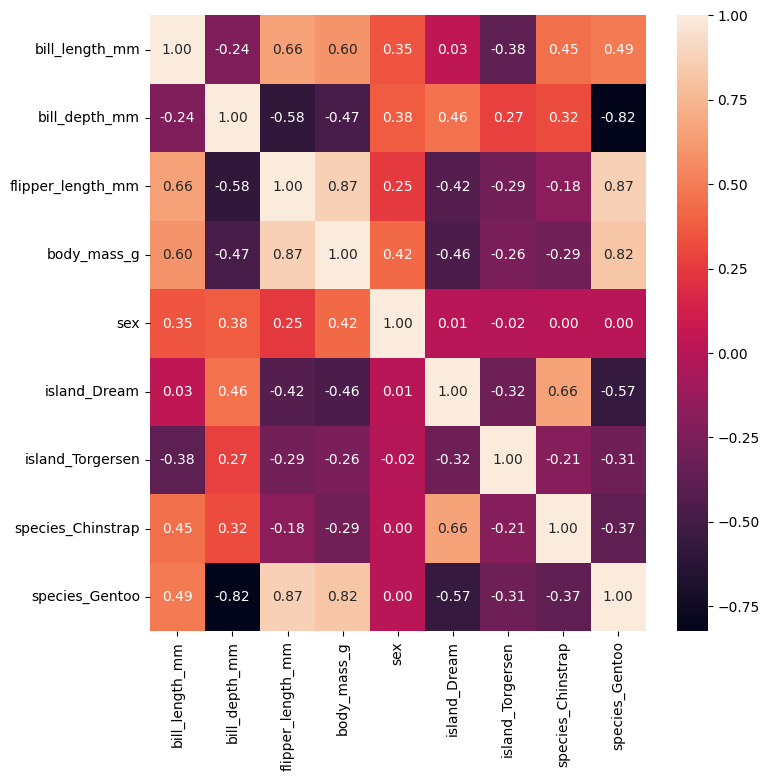

In [251]:
plt.figure(figsize=(8, 8))
sns.heatmap(ml_outpt_data.corr(), annot=True, fmt='.2f')
plt.show()

Видно, что очень сильно коррелированы между собой признаки `body_mass_g` и `flipper_lenght_mm`. Также очень хорошо признак `flipper_length_mm` коррелирует с признаками `bill_length_mm` и `bill_depth_mm`. Поэтому попробуем решать 2 задачи: предсказание `body_mass_g` и `flipper_lenght_mm` и задачу предсказания сразу 4 признаков.

Перечисленные задачи будем решать двумя способами MultioutputRegressor и RegressorChain.

## RegressorChain

### Первая задача

Разделим данные для первой задачи.

In [252]:
X = ml_outpt_data.drop(columns=['body_mass_g', 'flipper_length_mm'])
y = ml_outpt_data[['body_mass_g', 'flipper_length_mm']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Зададим нужный порядок предсказания

In [253]:
y = y[['flipper_length_mm', 'body_mass_g']]

#### Обучение моделей

**Обучим простую линейную регрессию.**

In [254]:
chain_lr = RegressorChain(LinearRegression())

chain_lr_param_grid = {
    'base_estimator__fit_intercept': [True, False]
}

chain_lr = GridSearchCV(
    estimator=chain_lr,
    param_grid=chain_lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'base_estimator__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

**Обучим Lasso-регрессию**

In [255]:
chain_lasso = RegressorChain(Lasso())

chain_lasso_param_grid = {
    'base_estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

chain_lasso = GridSearchCV(
    estimator=chain_lasso,
    param_grid=chain_lasso_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=Lasso()), n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

**Обучим Ridge-регрессию.**

In [256]:
chain_ridge = RegressorChain(Ridge())

chain_ridge_param_grid = {
    'base_estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

chain_ridge = GridSearchCV(
    estimator=chain_ridge,
    param_grid=chain_ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=Ridge()), n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

#### Оценка моделей

Теперь оценим качество полученных моделей.

In [257]:
np_round = np.vectorize(lambda x: round(x, 2))

models = [chain_lr, chain_lasso, chain_ridge]

matrix = dict()
matrix['models'] = ['linear regression', 'lasso regression', 'ridge regression']
matrix['flipper_length_mm'] = []
matrix['body_mass_g'] = []
matrix['avg'] = []

for model in models:
    flipper_length_mm_loss, body_mass_g_loss =\
     np_round(mean_absolute_percentage_error(y_test, model.predict(X_test), multioutput='raw_values')) * 100
    avg_loss = round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 2) * 100

    matrix['flipper_length_mm'].append(flipper_length_mm_loss)
    matrix['body_mass_g'].append(body_mass_g_loss)
    matrix['avg'].append(avg_loss)

In [279]:
chain_matrix = pd.DataFrame(matrix)

In [278]:
chain_matrix

,models,flipper_length_mm,body_mass_g,avg
0,linear regression,7.0,2.0,4.0
1,lasso regression,10.0,6.0,8.0
2,ridge regression,7.0,2.0,4.0


Лучшим образом показали себя простая линейная регрессия b ridge регрессия. Средняя ошибка в 4%, как мне кажется, является достаточно хорошей.

Ошибка для каждого последующего признака падает, как и говорится в RegressorChain. Так что всё правильно и всё логично.

Lasso тут показало качество хуже, так как выбросы в данных могли быть, а вот бесполезных признаков точно нет (мы это видели на матрице корреляций).

### Вторая задача

Разделим данные для второй задачи.

In [259]:
X = ml_outpt_data.drop(columns=['body_mass_g', 'flipper_length_mm', 'bill_depth_mm', 'bill_length_mm'])
y = ml_outpt_data[['body_mass_g', 'flipper_length_mm', 'bill_depth_mm', 'bill_length_mm']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Игра с порядком обучения

В RegressorChain предсказания происходят последовательно, предсказанный признак используется для предсказания последующих признаков. Поэтому логично, что порядок важен, попрубуем проверить это.

Проведём обучение для порядка `body_mass_g`, `flipper_length_mm`, `bill_depth_mm`, `bill_length_mm`.

In [260]:
y_temp_1 = ml_outpt_data[['body_mass_g', 'flipper_length_mm', 'bill_depth_mm', 'bill_length_mm']]
X_train_temp1, X_test_temp1, y_train_temp1, y_test_temp1 = train_test_split(X, y_temp_1, test_size=0.2, random_state=42)

chain_lr = RegressorChain(LinearRegression())

chain_lr_param_grid = {
    'base_estimator__fit_intercept': [True, False]
}

chain_lr_temp1 = GridSearchCV(
    estimator=chain_lr,
    param_grid=chain_lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lr_temp1.fit(X_train_temp1, y_train_temp1)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'base_estimator__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

Проведём обучение для порядка `bill_depth_mm`, `bill_length_mm`, `flipper_length_mm`, `body_mass_g`.

In [261]:
y_temp_2 = ml_outpt_data[['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm', 'body_mass_g']]
X_train_temp2, X_test_temp2, y_train_temp2, y_test_temp2 = train_test_split(X, y_temp_2, test_size=0.2, random_state=42)

chain_lr = RegressorChain(LinearRegression())

chain_lr_param_grid = {
    'base_estimator__fit_intercept': [True, False]
}

chain_lr_temp2 = GridSearchCV(
    estimator=chain_lr,
    param_grid=chain_lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lr_temp2.fit(X_train_temp1, y_train_temp1)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'base_estimator__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

**Сравним качество.**

Порядок 1.

In [262]:
np_round(mean_absolute_percentage_error(y_test_temp1, chain_lr_temp1.predict(X_test_temp1), multioutput='raw_values')) * 100

array([7., 2., 3., 4.])

Порядок 2.

In [263]:
np_round(mean_absolute_percentage_error(y_test_temp2, chain_lr_temp2.predict(X_test_temp2), multioutput='raw_values')) * 100

array([146.,  54.,  13.,  14.])

**Вывод:**

Качество в первом случает очевидно, лучше. Это так из-за того, что `flipper_length_mm` сильно коррелирует с `body_mass_g`, а уже `flipper_lenght_mm` коррелирует с `bill_length_mm` и `bill_depth_mm`. Если мы пытаемся предсказывать признак, по некоррелирующему признаку (второй порядок), то качество, очевидно, получается очень плохим.

#### Обучение моделей

**Обучим простую линейную регрессию.**

In [264]:
chain_lr = RegressorChain(LinearRegression())

chain_lr_param_grid = {
    'base_estimator__fit_intercept': [True, False]
}

chain_lr = GridSearchCV(
    estimator=chain_lr,
    param_grid=chain_lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'base_estimator__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

**Обучим Lasso-регрессию**

In [265]:
chain_lasso = RegressorChain(Lasso())

chain_lasso_param_grid = {
    'base_estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

chain_lasso = GridSearchCV(
    estimator=chain_lasso,
    param_grid=chain_lasso_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=Lasso()), n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

**Обучим Ridge-регрессию.**

In [266]:
chain_ridge = RegressorChain(Ridge())

chain_ridge_param_grid = {
    'base_estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

chain_ridge = GridSearchCV(
    estimator=chain_ridge,
    param_grid=chain_ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

chain_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RegressorChain(base_estimator=Ridge()), n_jobs=-1,
             param_grid={'base_estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

#### Оценка моделей

Теперь оценим качество полученных моделей.

In [267]:
np_round = np.vectorize(lambda x: round(x, 2))

models = [chain_lr, chain_lasso, chain_ridge]

matrix = dict()
matrix['models'] = ['linear regression', 'lasso regression', 'ridge regression']
matrix['body_mass_g'] = []
matrix['flipper_length_mm'] = []
matrix['bill_depth_mm'] = []
matrix['bill_length_mm'] = []
matrix['avg'] = []

for model in models:
    body_mass_g_loss, flipper_length_mm_loss, bill_depth_mm_loss, bill_length_mm_loss =\
     np_round(mean_absolute_percentage_error(y_test, model.predict(X_test), multioutput='raw_values')) * 100
    avg_loss = round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 2) * 100

    matrix['body_mass_g'].append(body_mass_g_loss)
    matrix['flipper_length_mm'].append(flipper_length_mm_loss)
    matrix['bill_depth_mm'].append(bill_depth_mm_loss)
    matrix['bill_length_mm'].append(bill_length_mm_loss)
    matrix['avg'].append(avg_loss)

In [268]:
pd.DataFrame(matrix)

,models,body_mass_g,flipper_length_mm,bill_depth_mm,bill_length_mm,avg
0,linear regression,7.0,2.0,3.0,4.0,4.0
1,lasso regression,10.0,6.0,10.0,8.0,8.0
2,ridge regression,7.0,2.0,3.0,4.0,4.0


Тут картина с качеством примерно такая же, что и в предыдущей задаче.

## MultioutputRegressor

Данный подход использует независимые модели. То есть для каждой отдельной целевой переменной используется свой предсказатель. Это простой подход, но, как мне кажется, не эффективный и неточный, так как он не учитывает взаимосвязи между целевыми переменными, которые могут быть достаточно важными.

Вообще мне кажется данный метод избыточным, так как проще просто обучить две раздельных модели, а не пытаться никак не связанные предсказатели засовывать под капот одного (это уменьшает гибкость + просто выглядит глупо).

Для этого подхода будем решать только первую задачу, так как всё интересное для второй задачи мы уже посмотрели (на самом деле если просто выкинуть 4 столбца сразу, то ничего хорошего не выйдет).

Разделим данные для первой задачи.

In [269]:
X = ml_outpt_data.drop(columns=['body_mass_g', 'flipper_length_mm'])
y = ml_outpt_data[['body_mass_g', 'flipper_length_mm']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Зададим нужный порядок предсказания

In [270]:
y = y[['flipper_length_mm', 'body_mass_g']]

#### Обучение моделей

**Обучим простую линейную регрессию.**

In [271]:
multioutput_lr = MultiOutputRegressor(LinearRegression())

multioutput_lr_param_grid = {
    'estimator__fit_intercept': [True, False]
}

multioutput_lr = GridSearchCV(
    estimator=multioutput_lr,
    param_grid=multioutput_lr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

multioutput_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=LinearRegression()),
             n_jobs=-1, param_grid={'estimator__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

**Обучим Lasso-регрессию**

In [272]:
multioutput_lasso = MultiOutputRegressor(Lasso())

multioutput_lasso_param_grid = {
    'estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

multioutput_lasso = GridSearchCV(
    estimator=multioutput_lasso,
    param_grid=multioutput_lasso_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

multioutput_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=Lasso()), n_jobs=-1,
             param_grid={'estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

**Обучим Ridge-регрессию.**

In [273]:
multioutput_ridge = MultiOutputRegressor(Ridge())

multioutput_ridge_param_grid = {
    'estimator__alpha': np.arange(0.1, 2.0, 0.2)
}

multioutput_ridge = GridSearchCV(
    estimator=multioutput_ridge,
    param_grid=multioutput_ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

multioutput_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=Ridge()), n_jobs=-1,
             param_grid={'estimator__alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])},
             scoring='neg_mean_squared_error')

#### Оценка моделей

Теперь оценим качество полученных моделей.

In [274]:
np_round = np.vectorize(lambda x: round(x, 2))

models = [multioutput_lr, multioutput_lasso, multioutput_ridge]

matrix = dict()
matrix['models'] = ['linear regression', 'lasso regression', 'ridge regression']
matrix['flipper_length_mm'] = []
matrix['body_mass_g'] = []
matrix['avg'] = []

for model in models:
    flipper_length_mm_loss, body_mass_g_loss =\
     np_round(mean_absolute_percentage_error(y_test, model.predict(X_test), multioutput='raw_values')) * 100
    avg_loss = round(mean_absolute_percentage_error(y_test, model.predict(X_test)), 2) * 100

    matrix['flipper_length_mm'].append(flipper_length_mm_loss)
    matrix['body_mass_g'].append(body_mass_g_loss)
    matrix['avg'].append(avg_loss)

In [275]:
multioutput_matrix = pd.DataFrame(matrix)

In [276]:
multioutput_matrix

,models,flipper_length_mm,body_mass_g,avg
0,linear regression,7.0,2.0,4.0
1,lasso regression,10.0,6.0,8.0
2,ridge regression,7.0,2.0,4.0


На удивление качество получилось таким же, хотя, учитывая независимость моделей, оно должно быть хуже, видимо дело в данных.

## Итог

Могу сказать, что RegressorChains лучше, чем MultioutputRegressor (пусть это и не подтвердилось на данных :) ) + важно, чтобы целевые переменные в RegressorChains коррелировали между собой + важно соблюдать порядок.